In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
def PreparingData(pathfile,carmodelname,target): ##remove nulls in price
    df = pd.read_csv(pathfile)
    df = df[df['model_name'].isin([carmodelname])].reset_index(drop=True).drop(['feature_1','feature_2','feature_3','feature_4','feature_5','feature_6','feature_7','feature_8','feature_9','duration_listed','engine_has_gas','engine_type','has_warranty','is_exchangeable','location_region','number_of_photos','body_type','up_counter','feature_0','manufacturer_name','model_name'],axis=1)
    TargetVar = df[target]
    df.drop(columns=[target], axis=1,inplace=True)
    df.insert(0,target, TargetVar)
    df
    return df

In [3]:
Y = 'price_usd' # Y is the name of the column with dependent (target) variable
data = PreparingData('C:/Users/Gfreitas/Downloads/ModeloPreditivoCarrosUsados/cars.csv','Golf',Y)

In [4]:
#cardf.info()
#cardf.describe()

<AxesSubplot:xlabel='state', ylabel='price_usd'>

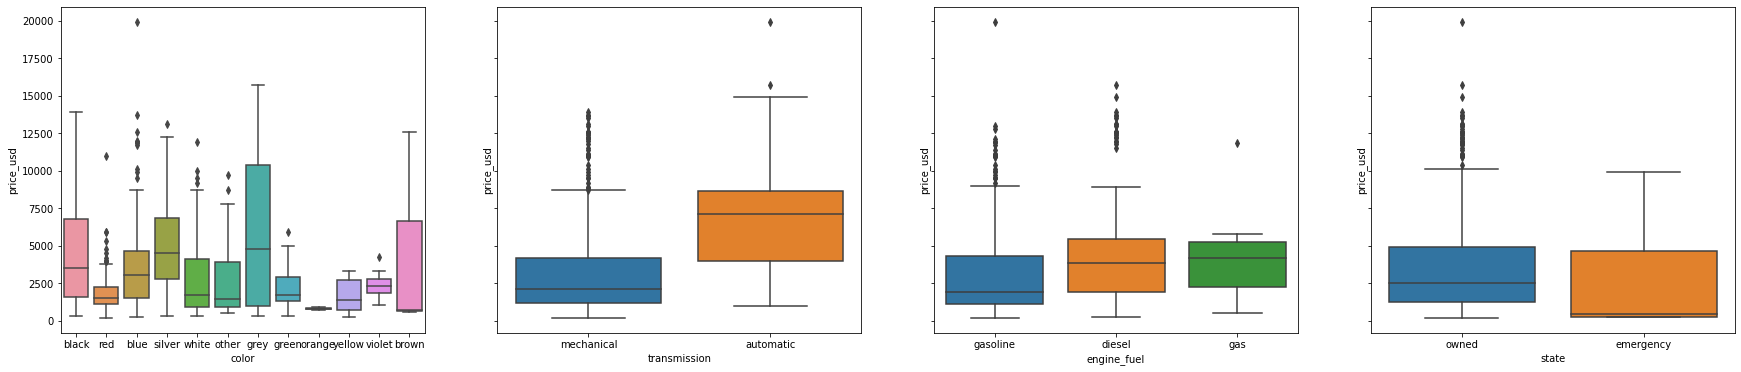

In [5]:
## Pipeline, count number of elements, loop creation
#print(vwjetta_df['drivetrain'].value_counts())
#print(vwjetta_df['state'].value_counts())
#print(vwjetta_df['transmission'].value_counts())
#print(vwjetta_df['color'].value_counts())
#print(vwjetta_df['engine_fuel'].value_counts())
## Show counts on plot
##iteract all columns minus Y
fig, axs = plt.subplots(ncols=4, figsize=(30,6),sharey=True)
sns.boxplot(x='color',y=Y,data=data, ax=axs[0])
sns.boxplot(x='transmission',y=Y,data=data, ax=axs[1])
sns.boxplot(x='engine_fuel',y=Y,data=data, ax=axs[2])
sns.boxplot(x='state',y=Y,data=data, ax=axs[3])

In [6]:
def Dummies(df,column):
    return pd.concat([df, pd.get_dummies(df[column])],axis=1).drop(column,axis=1)

In [7]:
#adapt to transform all non numeric columns to dummies
cardf = Dummies(data,['transmission','state','engine_fuel','drivetrain','color'])

In [8]:
#cardf.corr()

In [9]:
#Vamos Analisar a significância estatística das variáveis em comparação com o preço (price_usd).
#Neste projeto, p < 0.05 é definido como estatisticamente significante, ou seja, uma confiança de >95% de que a correlação entre os dados é significante, e não uma coincidência.
#Pipeline?
def CoefPearson(df,target):
    lcoef = []
    lp = []
    for x in list(df.columns):
        coef, p = stats.pearsonr(df[x],df[target])
        lcoef.append(round(coef,2))
        lp.append(round(p,2))
    return pd.DataFrame(lcoef).merge(pd.DataFrame(lp),on=df.columns).rename(columns={'key_0':'IndependentVar','0_x':'PearsonCoef','0_y':'P-Value'}).drop([0]).reset_index(drop=True)

def FilterP(df,plimit):
    return df[df['P-Value'] <= 0.05].reset_index(drop=True)

def ListP(df,plimit):   # MLR variable list (use less?)
    df = FilterP(df,plimit)
    return list(df['IndependentVar'])

def ListMaxAbsCoef(df): #PR and SLR variable list
    return list(df.loc[df['PearsonCoef'].abs().idxmax()])

In [10]:
#Teste de ANOVA (Analise de Variância)
#O teste de ANOVA testa a significância da variação das médias entre grupos de uma mesma variável.
#Dois parâmetros são observados no teste ANOVA: Teste_F e Valor_P.
#Teste_F: ANOVA assume que a hipótese que a média entre os grupos é a mesma, e quantifica o desvio da média calculada pela média assumida. Quanto maior o Teste_F, maior a diferença entre médias.
#Valor_P: Indica o quão estatisticamente significante é o valor de Teste_F.
###move price column to end and remove from loop
#def Anova(df):
#    for x in list(df.columns):
#        f_val, p_val = stats.f_oneway(df[x],TargetVar)
#        print("ANOVA",x,"x Price: F-Value=", round(f_val,2),"P-Value:", round(p_val,2))
#    return 

#compare in groups of same variable
#Anova(cardf)
#grp_year_produced=vwjetta_df[['year_produced', 'price_usd']].groupby(['year_produced'])
#grp_year_produced.head()

Model Equation: Predicted Price = -687740.0671526314 + ( 346.0436035430563 * Year Produced)


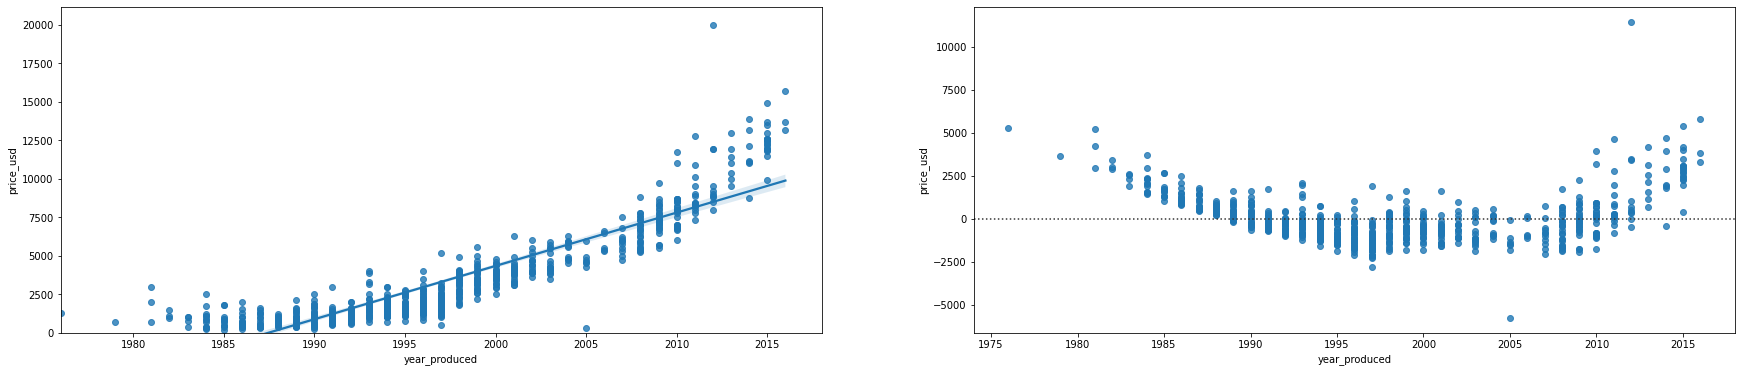

In [11]:
#Regressão Linear Simples + Residual Plot
BestIndVar = ListMaxAbsCoef(FilterP(CoefPearson(cardf,Y),0.05))
TargetVar = cardf[Y]
lm = LinearRegression()
x = cardf[BestIndVar[0]]
X = cardf[[BestIndVar[0]]]
lm.fit(X,TargetVar)
fig, axs = plt.subplots(ncols=2, figsize=(30,6))
ax0 = sns.regplot(x=X,y=TargetVar,data=cardf,ax=axs[0])
ax1 = sns.residplot(x=X,y=TargetVar,data=cardf,ax=axs[1])
ax0.set_ylim(0,)
ax0.set_xlim(x.min(),)
print('Model Equation: Predicted Price =',lm.intercept_,'+ (',float(lm.coef_),'*','Year Produced)')
#Residual plot shows that linear regression is not a good model (curvy residual)

In [12]:
#Regressão Linear Múltipla
lm1 = LinearRegression()
Z = cardf[ListP(CoefPearson(cardf,Y),0.05)]
lm1.fit(Z,TargetVar)
print("Ponto de Interceptação:",lm1.intercept_)
print("Coeficientes:",lm1.coef_)
#print('Equação do Modelo: Preço = ',lm1.intercept_,'+ (',lm1.coef_[0],'*','Odômetro)+(',lm1.coef_[1],'*','Ano Produzido)+(',lm1.coef_[2],'*','Automático? 1-Sim, 0-Não)+(',lm1.coef_[3],'*','Acidentes? 1-Sim, 0-Não)')

Ponto de Interceptação: -630565.3149226794
Coeficientes: [-3.17081450e-04  3.18943961e+02 -1.17800576e+03  4.26375967e+02
 -4.26375967e+02  7.15256532e+02  1.02367296e+02  2.29076579e+03
 -1.02611801e+03  2.28333812e+02 -9.78165474e+01  8.98108080e+02
 -1.66675139e+02 -1.99738603e+02 -1.34495672e+02]


(0.0, 23980.683318859756)

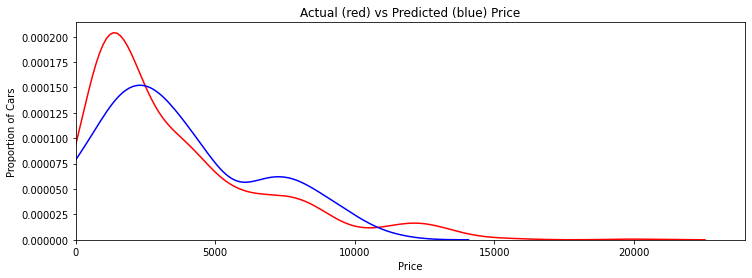

In [13]:
Y_hat = lm1.predict(Z)
plt.figure(figsize=(12,4))
ax1 = sns.kdeplot(TargetVar, color="r", label="Actual Value")
sns.kdeplot(Y_hat, color="b", label="Predicted Values", ax=ax1)

plt.title('Actual (red) vs Predicted (blue) Price')
plt.xlabel('Price')
plt.ylabel('Proportion of Cars')
plt.xlim(0,)

        3        2
0.1785 x - 1056 x + 2.084e+06 x - 1.371e+09


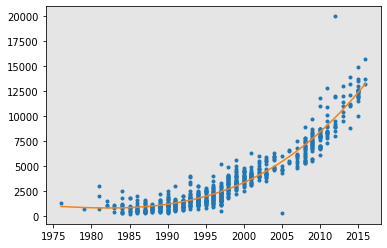

In [14]:
#Regressao Polinomial
def PlotPolly(model, X, Y):
    x_new = np.linspace(x.min(),x.max())
    y_new = model(x_new)
    plt.plot(X, TargetVar, '.', x_new, y_new, '-')
    ax = plt.gca()
    ax.set_facecolor((0.898, 0.898, 0.898))
    fig = plt.gcf()
    plt.show()
    plt.close()

p = np.poly1d(np.polyfit(x, TargetVar, 3)) #3 degrees polynomial. can be adjusted further
print(p)
PlotPolly(p, x, TargetVar)

In [15]:
def R2andMSE(realY,predictY):
    print('R2:',r2_score(realY,predictY))
    print('MSE:',mean_squared_error(realY, predictY))
    return

def SLR_Pred(model,independent_variable):
    return round((float((model.coef_*independent_variable)+model.intercept_)),2)

def MLR_Pred(model,independent_variable): #adapt to get independent variables as list and loop
    return round(((model.coef_[0]*Odometro)+(model.coef_[1]*Ano)+(model.coef_[2]*Automatico)+(model.coef_[3]*Acidente)+model.intercept_),2)

def PR_Pred(model,independent_variable): #adapt to get any polinomial and loop
    return round(((model[0])+(model[1]*(independent_variable))+(model[2]*(independent_variable**2))+(model[3]*(independent_variable**3))),2)

In [16]:
##Adapt to compare models and select the best with MSE or r2 (user choice)
##show as table?
print('SLR R2 and MSE:')
R2andMSE(TargetVar,lm.predict(X))
print('MLR R2 and MSE:')
R2andMSE(TargetVar,lm1.predict(Z))
print('RP R2 and MSE:')
R2andMSE(TargetVar,p(x))
#Predições
Var = 2010
Ano = 2010
Odometro = 120000
Automatico = 1
Acidente = 0
Auto = 'Automático' if Automatico==1 else 'Manual'
Ac = 'Acidentado' if Acidente==1 else 'Não Acidentado'
print('SLR predicted price:',SLR_Pred(lm,Var))
print('MLR predicted price:',MLR_Pred(lm1,Var))#change independent variables when adapting function
print('RP predicted price:',PR_Pred(p,Var))

SLR R2 and MSE:
R2: 0.8134058215471239
MSE: 1917327.5345821206
MLR R2 and MSE:
R2: 0.8378731807182902
MSE: 1665915.9319997022
RP R2 and MSE:
R2: 0.9202584402467222
MSE: 819375.4458641758
SLR predicted price: 7807.58
MLR predicted price: 9295.99
RP predicted price: 8356.24
